In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.fft import fftn, ifftn, fftfreq,fft
from spectral_derivative import  calc_deriv_fftn_with_ext,calc_deriv_in_frequency_space
import os
import pynumdiff

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


# Calculates the spectral derivative for n-dimensional input and order
# Takes ax and d as liste e.g. ax = [0], d =[0.1]
# From my bachelor thesis: Linear Physical Law Learning
#https://github.com/HillaryHauger/linear-physical-law-learning/blob/main/frequency_method_functions.ipynb

2023-09-11 16:55:47,165 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2023-09-11 16:55:47,189 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2023-09-11 16:55:47,195 [INFO] 
Limited Linear Model Support Detected! 
---> CVXPY is not installed. 
---> Install CVXPY to use lineardiff derivatives 
You can still use other methods 



# Exponential function: $u(t,x)=(x+bt)exp(at)$
Which solves only $u_t=au+bu_x$.

In [227]:
a = 1
b = 2
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

#u = (xv + b*tv) * np.exp(a*tv)
u= np.exp(xv-a*tv)
#Add noise
target_noise=1e-7
var = target_noise * np.sqrt(np.mean(np.square(u)))
u_noise = u + np.random.normal(0, var, size=u.shape)

dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0,drop_endpoints=False)._differentiate(u, dx)

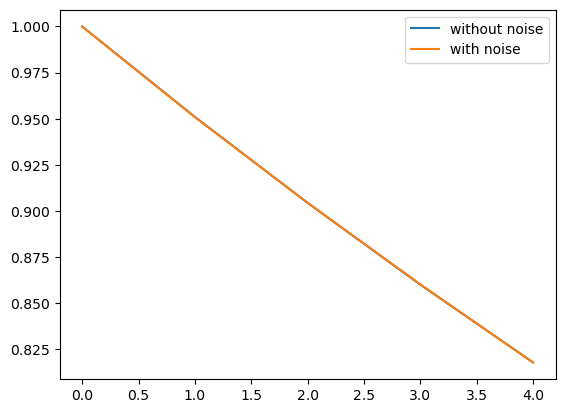

In [228]:
n=5#len(u)
plt.plot(u[0][:n],label='without noise')
plt.plot(u_noise[0][:n],label='with noise')
plt.legend()
plt.show()

In [229]:
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 50})
ux_noise_sindy = sfd._differentiate(u_noise, x)
ux_noise = ps.FiniteDifference(d=1, axis=0,drop_endpoints=False)._differentiate(u_noise, dx)
ux_noise_myfft = calc_deriv_fftn_with_ext(u_noise,[x,t],[0],[dx])

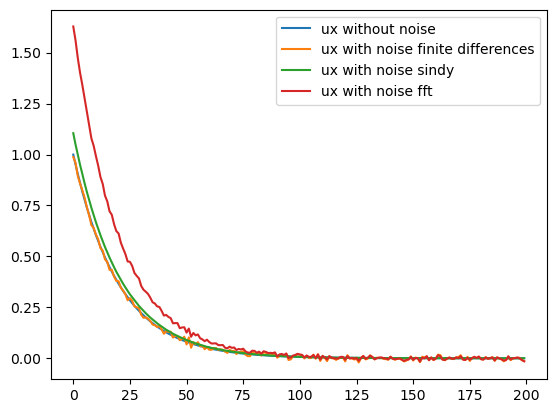

In [215]:
plt.plot(ux[0],label='ux without noise')
plt.plot(ux_noise[0],label='ux with noise finite differences')
plt.plot(ux_noise_sindy[0],label='ux with noise sindy')
plt.plot(ux_noise_myfft[0],label='ux with noise fft')
plt.legend()
plt.show()

In [217]:
u = u.reshape(len(x), len(t), 1)
u_noise = u_noise.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
print(' Without noise:')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()
print('  With noise:')
model.fit(u_noise, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print(' Without noise:')
model.fit(u, t=dt)
model.print()
print('  With noise:')
model.fit(u_noise, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print(' Without noise:')
model.fit(u, t=dt)
model.print()
print('  With noise:')
model.fit(u_noise, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print(' Without noise:')
model.fit(u, t=dt)
model.print()
print('  With noise:')
model.fit(u_noise, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print(' Without noise:')
model.fit(u, t=dt)
model.print()
print('  With noise:')
model.fit(u_noise, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print(' Without noise:')
model.fit(u, t=dt)
model.print()
print('  With noise:')
model.fit(u_noise, t=dt)
model.print()

STLSQ model: 
 Without noise:
(x0)' = -1.202 x0 + 0.202 x0_1
  With noise:
(x0)' = -1.202 x0 + 0.202 x0_1
SR3 model, L0 norm: 
 Without noise:


/home/groups/ai/hauger/miniconda3/envs/uniq/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


(x0)' = -1.202 x0 + 0.202 x0_1
  With noise:


/home/groups/ai/hauger/miniconda3/envs/uniq/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


(x0)' = -1.202 x0 + 0.202 x0_1
SR3 model, L1 norm: 
 Without noise:


/home/groups/ai/hauger/miniconda3/envs/uniq/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


(x0)' = 0.008 1 + -1.203 x0 + 0.203 x0_1
  With noise:


/home/groups/ai/hauger/miniconda3/envs/uniq/lib/python3.8/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


(x0)' = 0.008 1 + -1.203 x0 + 0.203 x0_1
SSR model: 
 Without noise:
(x0)' = -1.202 x0 + 0.202 x0_1
  With noise:
(x0)' = -1.202 x0 + 0.202 x0_1
SSR (metric = model residual) model: 
 Without noise:
(x0)' = -0.014 1 + -1.003 x0 + 0.002 x0_1
  With noise:
(x0)' = -0.014 1 + -1.003 x0 + 0.002 x0_1
FROLs model: 
 Without noise:
(x0)' = -1.000 x0
  With noise:
(x0)' = -1.000 x0


Weirdly onyl some algorithms find the correct terms and some even add weird intercepts.
## Check the rank of the matrix, as we have uniqueness for linear PDEs
We cannot directly check the matrix rank of $(u(t_i,x_j),u_x(t_i,x_j))(\mathbb{R}^{n\times m})^2$ as both are themselves already matrices or even higher dimensional linear forms. Linear dependence of the function is equal to linear dependence of the matrices, which translates to linear dependence of the vectorized versions of $(u(t_i,x_j),u_x(t_i,x_j))\in\mathbb{R}^{nm\times2}$.

In [2]:
from numpy.linalg import matrix_rank, svd

def compute_distance_svs(u,dx,fd_orders=range(2,8)):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
    
        u_flat, u_x_flat = u.flatten(), ux.flatten()
        features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
        svs = svd(features, compute_uv=False)
        distance_svs.append(svs[-1])
    return distance_svs

### Without noise

In [24]:
#Without noise
ux = ps.FiniteDifference(order=1, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux.flatten()
g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print( matrix_rank(g), svd(g, compute_uv=False))
distance_svs = compute_distance_svs(u,dx)

2 [398969.90110584   1617.33737778]


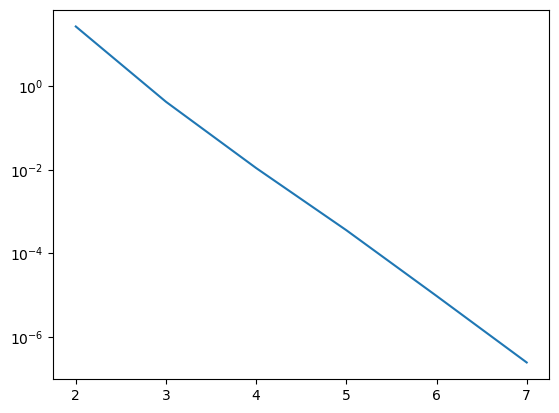

In [21]:
plt.plot(range(2,8), distance_svs)
plt.yscale('log')

### With noise

In [22]:
#With noise
ux_noise = ps.FiniteDifference(order=20, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))
distance_svs_noise = compute_distance_svs(u_noise,dx)

2 [3.96035814e+05 2.68837491e-05]


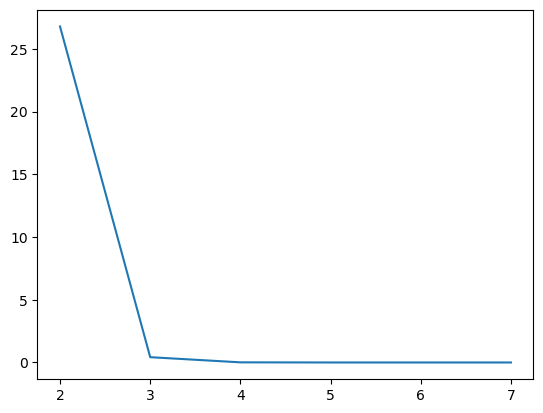

In [23]:
plt.plot(range(2,8), distance_svs_noise)
#plt.yscale('log')

## Compare different differentiaiton techniques

In [32]:
a = 1
b = 2
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

#u = (xv + b*tv) * np.exp(a*tv)
u= np.exp(xv-a*tv)
#Add noise
target_noise=1e-6
var = target_noise * np.sqrt(np.mean(np.square(u)))
u_noise = u + np.random.normal(0, var, size=u.shape)
dx = x[1] - x[0]


Noise level: 0
1 [3.96035814e+05 6.41246556e-08]
Noise level: 1e-10
2 [3.96035814e+05 4.63059892e-03]
Noise level: 1e-09
2 [3.96035813e+05 4.60288353e-02]
Noise level: 1e-08
2 [3.96035816e+05 4.93126775e-01]
Noise level: 1e-07
2 [3.96035752e+05 4.79323876e+00]
Noise level: 1e-06
2 [3.96036482e+05 4.65190906e+01]
Noise level: 1e-05
2 [396049.28481102    493.78006655]
Noise level: 0.0001
2 [396100.33046478   4892.25553737]
Noise level: 0.001
2 [399190.64764728  47622.58032046]
Noise level: 0.01
2 [694764.75250143 249347.96849498]
Noise level: 0.1
2 [6839144.71945402  281229.95897179]


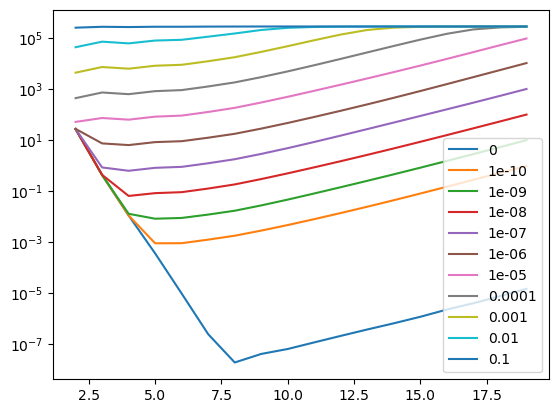

In [38]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    var = target_noise * np.sqrt(np.mean(np.square(u)))
    u_noise = u + np.random.normal(0, var, size=u.shape)
    ux_noise = ps.FiniteDifference(order=10, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))
    m=20
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")

In [ ]:
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 50})
ux_noise_sindy = sfd._differentiate(u_noise, x)
ux_noise_fd = ps.FiniteDifference(order=2,d=1, axis=0,drop_endpoints=False)._differentiate(u_noise, dx)
ux_noise_myfft = calc_deriv_fftn_with_ext(u_noise,[x,t],[0],[dx])
deriv = [ux_noise_sindy,ux_noise_fd,ux_noise_myfft]

In [5]:
for ux in deriv:
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))

NameError: name 'deriv' is not defined

## Check wether conversion to Fourier Space helps?

In [29]:
u_fft = fftn(u_noise)
ux_fft = calc_deriv_in_frequency_space(u_noise,[0],[dx])

In [19]:
u_flat, u_x_flat = u_fft.flatten(), ux_fft.flatten()
g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print( matrix_rank(g), svd(g, compute_uv=False))
distance_svs = compute_distance_svs(u,dx)

2 [6.20778237e+08 6.85954036e+07]
